In [1]:
import pandas as pd
from rdrobust import rdrobust, rdplot
from rddensity import rddensity
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS

# Data Loading and Preparation
headstart_data = pd.read_stata('/Users/veronica/Dropbox/PhD/2024_2/EC_709/PSETS_EC709/PSET2/headstart.dta')
cutoff_value = 59.1984

covariates_1960 = headstart_data[['census1960_pop', 'census1960_pctsch1417', 'census1960_pctsch534', 
                                  'census1960_pctsch25plus', 'census1960_pop1417', 'census1960_pop534', 
                                  'census1960_pop25plus', 'census1960_pcturban', 'census1960_pctblack']]

headstart_data['running_variable'] = headstart_data['povrate60'] - cutoff_value
headstart_data = headstart_data[(headstart_data['mort_age59_related_postHS'].notna() & 
                                 headstart_data['povrate60'].notna() & 
                                 headstart_data['running_variable'].notna()) & 
                                (headstart_data['running_variable'] != np.inf)]

outcome_variable = headstart_data['mort_age59_related_postHS']
raw_running_variable = headstart_data['povrate60']
running_variable = headstart_data['running_variable']
treatment_indicator = (running_variable >= 0).astype(int)

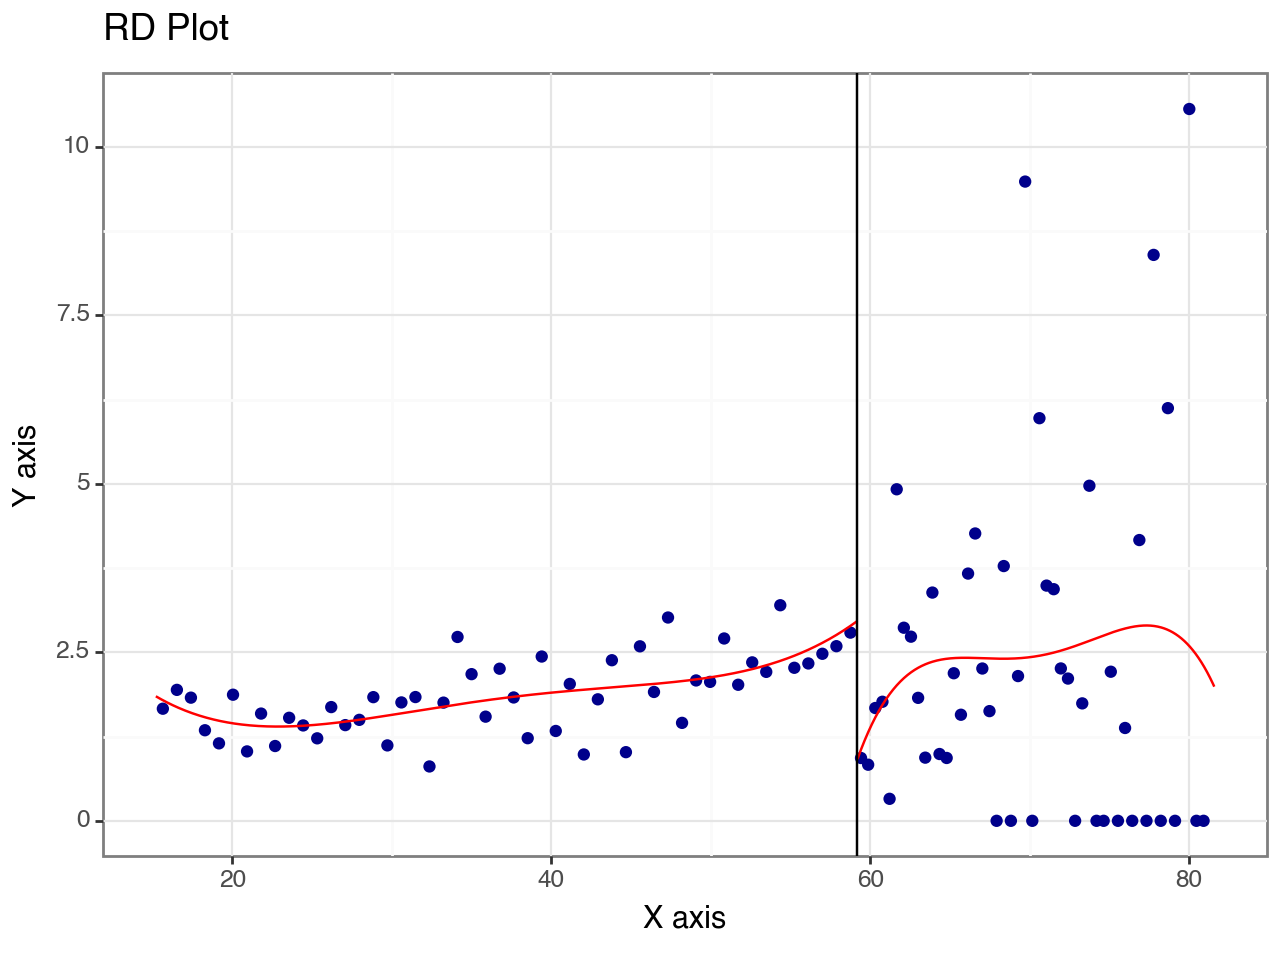

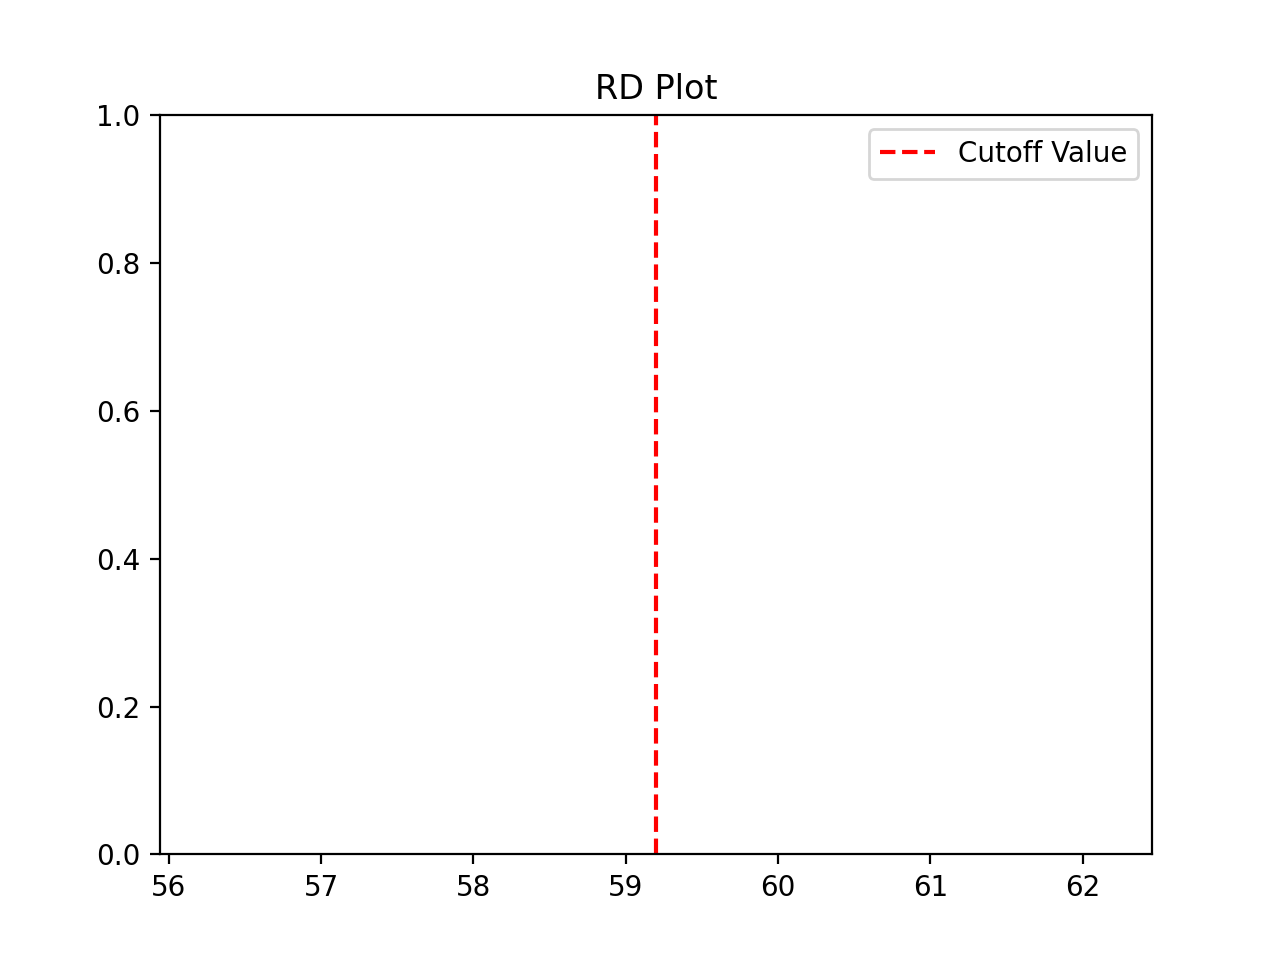

In [7]:
# Scatter Plot and RD Analysis
valid_indices = (outcome_variable < 20) & (outcome_variable.notna()) & (raw_running_variable.notna())
# RD plot with adjusted parameters
rdplot(outcome_variable[valid_indices], raw_running_variable[valid_indices], 
       c=cutoff_value, nbins=50)  # Try reducing nbins for simplicity
plt.title('RD Plot')
plt.axvline(x=cutoff_value, color='red', linestyle='--', label='Cutoff Value')
plt.legend()
plt.savefig('/Users/veronica/Dropbox/Apps/Overleaf/EC_709_vcperez/PSET_2/rd_plot.png')
plt.show()

## RD plot

In [85]:
# RD Estimation
rd_results = rdrobust(y=outcome_variable, x=running_variable, c=0)
print(rd_results)

# Manipulation Test
density_test = rddensity(X=running_variable, c=0)
print(density_test)

# OLS Regression for Comparison
X = np.column_stack((running_variable, treatment_indicator))
ols_model = OLS(outcome_variable, X).fit()
print(ols_model.summary())


Call: rdrobust
Number of Observations:                  2783
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          2489        294
Number of Unique Obs.           2489        294
Number of Effective Obs.         234        180
Bandwidth Estimation           6.811      6.811
Bandwidth Bias                10.726     10.726
rho (h/b)                      0.635      0.635

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -2.409    1.206   -1.998   4.570e-02   [-4.772, -0.046]
Robust                 -        -   -2.032   4.213e-02   [-5.462, -0.099]

Call: rddensity

Sample Size

In [96]:
# Results 

# Step 2: Extract necessary results
bandwidth_left = rd_results.bws.iloc[0]['left']
bandwidth_right = rd_results.bws.iloc[1]['left']
coef = rd_results.coef.iloc[0]['Coeff']
ci_lower = rd_results.ci.iloc[0]['CI Lower']
ci_upper = rd_results.ci.iloc[0]['CI Upper']
p_value = rd_results.pv.iloc[0]['P>|t|']
N_left = rd_results.N_h[0]
N_right = rd_results.N_h[1]

# Step 3: Create a summary DataFrame
rd_summary = {
    'Bandwidth Left': [bandwidth_left],
    'Bandwidth Right': [bandwidth_right],
    'Coefficient': [coef],
    'CI Lower': [ci_lower],
    'CI Upper': [ci_upper],
    'P-value': [p_value],
    'Observations Left': [N_left],
    'Observations Right': [N_right]
}

# Convert to DataFrame
rd_df = pd.DataFrame(rd_summary)

# Step 4: Export to LaTeX format
latex_output = rd_df.to_latex(index=False, float_format="%.3f")

# Save the LaTeX table to a file
with open("/Users/veronica/Dropbox/Apps/Overleaf/EC_709_vcperez/PSET_2/Q2_1_rd_robust_results.tex", "w") as file:
    file.write(latex_output)

# Parametric results

In [97]:
# Initialize storage for parametric RD results
parametric_results = []

# Loop over different polynomial orders and bandwidths
for p in [1, 4]:  # 1 for linear, 4 for quartic
    for h in [9, 18, 20, 100]:  # Different bandwidths
        selected_indices = abs(running_variable) <= h

        if selected_indices.sum() > 0:
            # Create polynomial terms of running variable
            X_poly = np.column_stack([running_variable[selected_indices] ** i for i in range(1, p+1)])
            
            # Create design matrix with treatment indicator and polynomial terms
            X_design = np.column_stack((treatment_indicator[selected_indices], X_poly))
            
            # Fit OLS model
            model = OLS(outcome_variable[selected_indices], X_design).fit()
            
            # Extract treatment effect (the first coefficient corresponds to the treatment indicator)
            treatment_effect = model.params[0]
            conf_int = model.conf_int().iloc[0]
            
            # Append results: polynomial order, bandwidth, treatment effect, confidence interval
            parametric_results.append([p, h, treatment_effect, conf_int])
    
# Convert results to DataFrame
parametric_df = pd.DataFrame(parametric_results, columns=['Order', 'Bandwidth', 'Treatment Effect', 'Confidence Interval'])

In [99]:
# Convert results to DataFrame
parametric_df = pd.DataFrame(parametric_results, columns=['Order', 'Bandwidth', 'Treatment Effect', 'Confidence Interval'])

# Export the DataFrame to LaTeX format
latex_output = parametric_df.to_latex(index=False, float_format="%.3f")

# Save the LaTeX table to a file
with open("/Users/veronica/Dropbox/Apps/Overleaf/EC_709_vcperez/PSET_2/Q2_parametric_results_table.tex", "w") as file:
    file.write(latex_output)

## Robust Nonparametric

In [70]:
#############################################################
## Table 4: Robust Nonparametric Local Polynomial Methods
#############################################################

# Initialize storage for local polynomial RD results
local_poly_results = []

# Loop over local constant (p=0) and local linear (p=1) polynomials
for p in [0, 1]:  
    for h in [None, 9]:  # None for default bandwidth, 9 for fixed bandwidth
        # Run rdrobust with or without fixed bandwidth
        if h is None:
            result = rdrobust(outcome_variable, running_variable, p=p)
        else:
            result = rdrobust(outcome_variable, running_variable, p=p, h=h)
        
        # Extract necessary results
        bandwidth_left = result.bws.iloc[0]['left']
        bandwidth_right = result.bws.iloc[1]['left']
        coef = result.coef.iloc[0]['Coeff']
        ci_lower = result.ci.iloc[0]['CI Lower']
        ci_upper = result.ci.iloc[0]['CI Upper']
        p_value = result.pv.iloc[0]['P>|t|']
        N_left = result.N_h[0]
        N_right = result.N_h[1]
        
        # Append results for this model
        local_poly_results.append([p, h if h is not None else 'Default', coef, ci_lower, ci_upper, p_value, N_left, N_right])

# Convert results to DataFrame
local_poly_df = pd.DataFrame(local_poly_results, columns=['Order', 'Bandwidth', 'Coefficient', 'CI Lower', 'CI Upper', 'P-value', 'N Left', 'N Right'])
print(local_poly_df.round(3))


   Order Bandwidth  Coefficient  CI Lower  CI Upper  P-value  N Left  N Right
0      0   Default       -2.114    -4.053    -0.174    0.033      98       92
1      0         9       -1.059    -2.196     0.079    0.068     309      215
2      1   Default       -2.409    -4.772    -0.046    0.046     234      180
3      1         9       -2.182    -4.340    -0.024    0.048     309      215


In [100]:
# Convert the local polynomial results DataFrame to LaTeX format
latex_output = local_poly_df.to_latex(index=False, float_format="%.3f")

# Save the LaTeX table to a file
with open("/Users/veronica/Dropbox/Apps/Overleaf/EC_709_vcperez/PSET_2/Q2_local_polynomial_results_table.tex", "w") as file:
    file.write(latex_output)


# Local randomization

In [74]:
# Initialize storage for local randomization results
local_rand_results = []

# Define window widths around the cutoff (e.g., [-2, 2], [-1.5, 1.5], etc.)
window_widths = [(0, 2), (-2, 2), (-1.5, 1.5), (-1, 1)]  # Adjust these as needed

for window in window_widths:
    # Select data within the specified window
    selected_indices = (running_variable >= window[0]) & (running_variable <= window[1])
    
    # Fit the model within the selected window
    if selected_indices.sum() > 0:
        model = OLS(outcome_variable[selected_indices], treatment_indicator[selected_indices]).fit()
        
        # Store relevant results
        coef = model.params[0]
        ci_lower, ci_upper = model.conf_int().iloc[0]
        p_value = model.pvalues[0]
        local_rand_results.append([window, coef, ci_lower, ci_upper, p_value])

# Convert results to DataFrame for display
local_rand_df = pd.DataFrame(local_rand_results, columns=['Window', 'Coefficient', 'CI Lower', 'CI Upper', 'P-value'])
print(local_rand_df.round(3))


        Window  Coefficient  CI Lower  CI Upper  P-value
0       (0, 2)        1.192     0.516     1.868    0.001
1      (-2, 2)        1.192    -0.732     3.115    0.222
2  (-1.5, 1.5)        1.099    -1.438     3.635    0.392
3      (-1, 1)        0.909    -0.757     2.575    0.280


In [101]:
# Convert the local randomization results DataFrame to LaTeX format
latex_output = local_rand_df.to_latex(index=False, float_format="%.3f")

# Save the LaTeX table to a file
with open("/Users/veronica/Dropbox/Apps/Overleaf/EC_709_vcperez/PSET_2/Q2_local_randomization_results_table.tex", "w") as file:
    file.write(latex_output)


# graphs

Coefficients
